In [7]:
import numpy as np
import pandas as pd
from matplotlib.sphinxext.mathmpl import fontset_choice
from validphys.api import API

In [8]:
fitname = "250218_mtop_alphas_iterated"

In [9]:
fit = API.fit(fit=fitname)

In [10]:
# We have to know the name of the alphas and mtop point prescriptions (alphas_pp and mtop_pp) to
# extract the theoryids. We need alphas_pp_id and mtop_pp_id to identify the .csv file
# corresponding to the alphas covmat and mtop used in the fit.
pps = fit.as_input()["theorycovmatconfig"]["point_prescriptions"]
for i, pp in enumerate(pps):
    if "mtop" in pp:
        mtop_pp_id = i
        mtop_pp = pp 
    elif "alphas" in pp:
        alphas_pp_id = i
        alphas_pp = pp
    else:
        continue

In [11]:
common_dict = dict(
    dataset_inputs={"from_": "fit"},
    fit=fit.name,
    fits=[fit.name],
    use_cuts="fromfit",
    metadata_group="nnpdf31_process",
)

theoryids_dict_mtop = ({
        "point_prescription": mtop_pp,
        "theoryid": {"from_": "theory"},
        "theory": {"from_": "fit"},
        "theorycovmatconfig": {"from_": "fit"},
    } | common_dict)

theoryids_dict_alphas= ({
        "point_prescription": alphas_pp,
        "theoryid": {"from_": "theory"},
        "theory": {"from_": "fit"},
        "theorycovmatconfig": {"from_": "fit"},
    } | common_dict)

In [12]:
# extract theory ids for mtop and alphas including their variations
theoryids_mtop = API.theoryids(**theoryids_dict_mtop)
theoryids_alphas = API.theoryids(**theoryids_dict_alphas)

theory_central = theoryids_mtop[0].id
theory_plus = [theoryids_mtop[2].id, theoryids_alphas[1].id]
theory_min = [theoryids_mtop[1].id, theoryids_alphas[2].id]

In [13]:
thcov_input_pdf = fit.as_input()["theorycovmatconfig"]["pdf"]

# Inputs for central theory (used to construct the mtop, alphas covmat).
inps_central = dict(theoryid=theory_central, pdf=thcov_input_pdf, **common_dict)

# Inputs for plus theory (used to construct the mtop, alphas covmat)
inps_plus = [dict(theoryid=theory_id_plus, pdf=thcov_input_pdf, **common_dict) for theory_id_plus in theory_plus]

# Inputs for minus theory prediction (used to construct the mtop, alphas covmat)
inps_min = [dict(theoryid=theory_id_min, pdf=thcov_input_pdf, **common_dict) for theory_id_min in theory_min]

# inputs for the computation of the prediction of the fit with cov=C+S, where S
# is computed using the inps_central, inps_plus, and inps_minus dictionaries
inps_central_fit = dict(theoryid=theory_central, pdf={"from_": "fit"}, **common_dict)

In [14]:
# if fit.as_input()["resample_negative_pseudodata"] != False:
#     print("The TCM assumes Gaussianity of the pseudodata, to ensure this set")
#     print("resample_negative_pseudodata: False")
#     print("in the n3fit runcard!")

In [15]:
# Get the prior theory predictions for the central values
prior_theorypreds_central = API.group_result_central_table_no_table(**inps_central)["theory_central"].to_frame() # shape (n_dat, 1)

# Get the prior theory predictions for the plus and minus variations
prior_theorypreds_plus = pd.concat([API.group_result_central_table_no_table(**inp_plus)["theory_central"] for inp_plus in inps_plus], axis=1)  # shape (n_dat, n_par)
prior_theorypreds_minus = pd.concat([API.group_result_central_table_no_table(**inp_min)["theory_central"] for inp_min in inps_min], axis=1)  # shape (n_dat, n_par)

LHAPDF 6.5.4 loading /Users/jaco/miniconda3/envs/nnpdf_dev/share/LHAPDF/250218_mtop_alphas_variation_test/250218_mtop_alphas_variation_test_0000.dat
250218_mtop_alphas_variation_test PDF set, member #0, version 1


In [16]:
# Get the values of mto
mtop_plus = API.theory_info_table(theory_db_id=theory_plus[0]).loc["mt"].iloc[0]
mtop_central = API.theory_info_table(theory_db_id=theory_central).loc["mt"].iloc[0]
mtop_min = API.theory_info_table(theory_db_id=theory_min[0]).loc["mt"].iloc[0]

# and alphas 
alphas_plus = API.theory_info_table(theory_db_id=theory_plus[1]).loc["alphas"].iloc[0]
alphas_central = API.theory_info_table(theory_db_id=theory_central).loc["alphas"].iloc[0]
alphas_min = API.theory_info_table(theory_db_id=theory_min[1]).loc["alphas"].iloc[0]

# and make sure the shift in both directions is symmetric
delta_plus = np.array([mtop_plus - mtop_central, alphas_plus - alphas_central])
delta_min = np.array([mtop_central - mtop_min, alphas_central - alphas_min]) 
if np.any(abs(delta_min - delta_plus) > 1e-6):
    raise ValueError("mtop shifts in both directions is not symmetric")
else:
    step_size = np.array(delta_min).reshape(-1, 1)

In [17]:
# At some point we scaled the covmat to account for higher order derivatives or
# to test depencence of the prior. It is not used in the final result
covmat_scaling_factor = 1 #fit.as_input().get("theorycovmatconfig",{}).get("rescale_alphas_covmat",1.0)

# Compute theory covmat S_tilde on the genuine predictions (as, mt)
beta_tilde = np.sqrt(covmat_scaling_factor) * (step_size / np.sqrt(2)) * np.array([[1, -1, 0, 0], [0, 0, 1, -1]])
S_tilde = beta_tilde @ beta_tilde.T

In [18]:
# TODO: why a npsqrt(2)
delta_plus = (np.sqrt(covmat_scaling_factor) / np.sqrt(2)) * (
    prior_theorypreds_plus - prior_theorypreds_central
)
delta_minus = (np.sqrt(covmat_scaling_factor) / np.sqrt(2)) * (
    prior_theorypreds_minus - prior_theorypreds_central
)

# Compute the theory cross covmat between the fitted predictions and the genuine predictions
beta = np.array([delta_plus.iloc[:, 0].values, delta_minus.iloc[:, 0].values, delta_plus.iloc[:, 1].values, delta_minus.iloc[:, 1].values]).T  # shape (n_dat, 2 * n_par)
S_hat = beta_tilde @ beta.T  # shape (n_par, n_dat)

# Compute the theory covmat on the theory predictions
S = beta @ beta.T 
S = pd.DataFrame(S, index=delta_minus.index, columns=delta_minus.index)  # shape (n_dat, n_dat)

In [19]:
eigvals = np.linalg.eigvals(S)

In [20]:
np.sum(np.abs(np.real(eigvals)) > 1)

4

In [21]:
# Sanity check: we want to check whether the stored theory covmat agrees with S

stored_alphas_covmat = pd.read_csv(
    fit.path / f"tables/datacuts_theory_theorycovmatconfig_point_prescriptions{alphas_pp_id}_theory_covmat_custom_per_prescription.csv",
    index_col=[0, 1, 2],
    header=[0, 1, 2],
    sep="\t|,",
    encoding="utf-8",
    engine="python",
).fillna(0)

stored_mtop_covmat = pd.read_csv(
    fit.path / f"tables/datacuts_theory_theorycovmatconfig_point_prescriptions{mtop_pp_id}_theory_covmat_custom_per_prescription.csv",
    index_col=[0, 1, 2],
    header=[0, 1, 2],
    sep="\t|,",
    encoding="utf-8",
    engine="python",
).fillna(0)

stored_covmat = stored_alphas_covmat + stored_mtop_covmat

storedcovmat_index = pd.MultiIndex.from_tuples(
    [(aa, bb, np.int64(cc)) for aa, bb, cc in stored_covmat.index],
    names=["group", "dataset", "id"],
)  

# make sure theoryID is an integer, same as in S
stored_covmat = pd.DataFrame(
    stored_covmat.values, index=storedcovmat_index, columns=storedcovmat_index
)
stored_covmat = stored_covmat.reindex(S.index).T.reindex(S.index)

if not np.allclose(S, stored_covmat):
    print("Reconstructed theory covmat, S, is not the same as the stored covmat!")

In [22]:
theorypreds_fit = API.group_result_table_no_table(**inps_central_fit).iloc[:, 2:]

LHAPDF 6.5.4 loading all 101 PDFs in set 250218_mtop_alphas_iterated
250218_mtop_alphas_iterated, version 1; 101 PDF members


In [23]:
# experimental covmat
C = API.groups_covmat(
    use_t0=True,
    datacuts={"from_": "fit"},
    t0pdfset={"from_": "datacuts"},
    theoryid= {"from_": "theory"},
    theory={"from_": "fit"},
    **common_dict
)

In [24]:
# Note that mean_prediction is different from the prediction of the mean PDF (i.e. replica0)
T0 = theorypreds_fit.mean(axis=1)
X = np.cov(theorypreds_fit, bias=True)

In [25]:
# In the computation we use <D>_rep and not the central value of the data D_exp, though if
# resample_negative_pseudodata: false
# is set in the n3fit runcard, D_exp and <D>_rep should be the same as N_rep -> inf.
pseudodata = API.read_pdf_pseudodata(**common_dict)
dat_reps = pd.concat(
    [i.pseudodata.reindex(prior_theorypreds_central.index) for i in pseudodata], axis=1
)

In [26]:
invcov = np.linalg.inv(C + S)

# delta_T_tilde is Eq. 3.37 in https://arxiv.org/pdf/2105.05114
delta_T_tilde = -S_hat @ invcov @ (T0 - dat_reps.mean(axis=1))

In [27]:

# P_tilde is Eq. 3.38.
#
# Note that not all terms of the equation in the paper are here, in particular
# X_tile and X_hat vanish. This is because they measure the covariance of
# T_tilde over PDF replicas, but for us T_tilde is alphas. The prediciton of
# alphas does not depend on the PDF, and as such T_tilde^(r) == T_tilde^(0)
P_tilde = S_hat @ invcov @ X @ invcov @ S_hat.T + S_tilde - S_hat @ invcov @ S_hat.T
central_theory = np.array([mtop_central, alphas_central])
pred = central_theory + delta_T_tilde

# print(rf"Prediction for $\m_{{top}}$: {pred:.4f} ± {P_tilde:.4f}")

In [28]:
pred

array([1.75086340e+02, 1.20138766e-01])

In [29]:
covmat_TCM = pd.DataFrame(P_tilde, index=["mt", "as"], columns=["mt", "as"])

In [30]:
covmat_TCM

,mt,as
mt,0.375685,9.042511e-05
as,0.000090,1.179726e-07


2.4517267600663173 0.0012406953717711065 -179.98620925690417


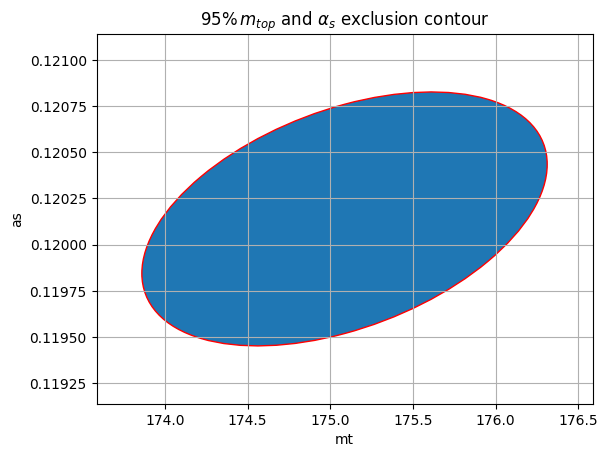

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an ellipse representing the covariance matrix `cov` centered at `pos`.
    
    Parameters:
    - cov: 2x2 covariance matrix
    - pos: Center of the ellipse (mean of the distribution)
    - nstd: Number of standard deviations to determine the ellipse's radii
    - ax: Matplotlib axis object (optional)
    - kwargs: Additional arguments for the Ellipse patch
    """
    if ax is None:
        ax = plt.gca()
    
    # Eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    # Sort the eigenvalues and eigenvectors
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    # Calculate the angle of the ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    
    # Width and height of the ellipse
    width, height = 2 * nstd * np.sqrt(eigvals)
    print(width, height, angle)
    
    # Create the ellipse patch
    ellip = Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)
    
    ax.add_patch(ellip)
    return ellip

fig, ax = plt.subplots()
plot_cov_ellipse(P_tilde, pred, ax=ax, edgecolor='red')
ax.set_xlim(pred[0] - 1.5, pred[0] + 1.5)
ax.set_ylim(pred[1] - 0.001, pred[1] + 0.001)
plt.xlabel('mt')
plt.ylabel('as')
plt.title(r"$95 \%\,m_{top}$ and $\alpha_s$ exclusion contour")
plt.grid(True)
plt.show()

In [80]:
from matplotlib import patches, transforms, rc
from matplotlib.patches import Ellipse
import scipy
rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", **{"usetex": True, "latex.preamble": r"\usepackage{amssymb}"})

def confidence_ellipse(
    cov, mean, ax, facecolor="none", confidence_level=95, **kwargs
):
    """
    Draws 95% C.L. ellipse for data points `x` and `y`

    Parameters
    ----------
    coeff1: array_like
        ``(N,) ndarray`` containing ``N`` posterior samples for the first coefficient
    coeff2: array_like
        ``(N,) ndarray`` containing ``N`` posterior samples for the first coefficient
    ax: matplotlib.axes
        Axes object to plot on
    facecolor: str, optional
        Color of the ellipse
    **kwargs
        Additional plotting settings passed to matplotlib.patches.Ellipse

    Returns
    -------
    matplotlib.patches.Ellipse
        Ellipse object

    """
    # diagonalise
    eig_val, eig_vec = np.linalg.eig(cov)

    # eigenvector with largest eigenvalue
    eig_vec_max = eig_vec[:, np.argmax(eig_val)]

    # angle of eigenvector with largest eigenvalue with the horizontal axis
    cos_th = eig_vec[0, np.argmax(eig_val)] / np.linalg.norm(eig_vec_max)
    if eig_vec_max[1] > 0:
        inclination = np.arccos(cos_th)
    else:
        # pay attention to range of arccos (extend to [0, -\pi] domain)
        inclination = -np.arccos(cos_th)

    eigval_sort = np.sort(eig_val)

    chi2_qnt = scipy.stats.chi2.ppf(confidence_level / 100.0, 2)

    ell_radius_x = np.sqrt(chi2_qnt * eigval_sort[-1])
    ell_radius_y = np.sqrt(chi2_qnt * eigval_sort[-2])

    ellipse = Ellipse(
        (0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs
    )

    mean_coeff1 = mean[0]
    mean_coeff2 = mean[1]
    
    transf = (
        transforms.Affine2D().rotate(inclination).translate(mean_coeff1, mean_coeff2)
    )
    
    # ax.set_xlim(pred[0] - ell_radius_x * 1.5, pred[0] + ell_radius_x * 1.5)
    # ax.set_ylim(pred[1] - ell_radius_y * 1.5, pred[1] + ell_radius_y * 1.5)

    ellipse.set_transform(transf + ax.transData)

    return ax.add_patch(ellipse)

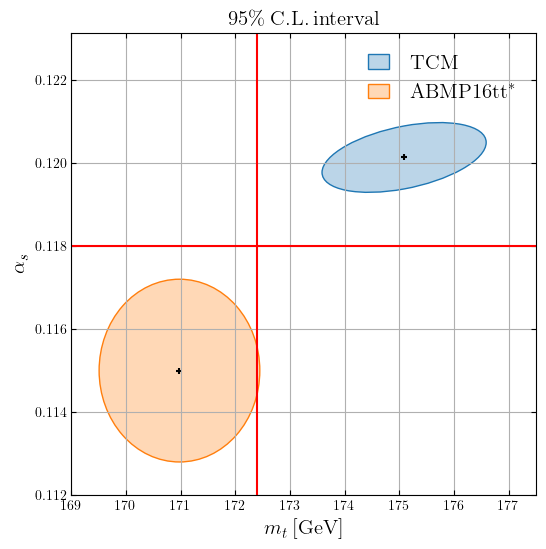

In [116]:
fig, ax = plt.subplots(figsize=(6,6))

p1 = confidence_ellipse(
            P_tilde,
            pred,
            ax=ax,
            alpha=1,
            edgecolor="C0",
            confidence_level=95,
        )

p2 = confidence_ellipse(
     P_tilde,
            pred,
            ax=ax,
            alpha=0.3,
            edgecolor=None,
            facecolor="C0",
            confidence_level=95,
)

ax.scatter(
        pred[0], pred[1],
        c='k',
        s=20,
        marker="+",
    )

hndls = (p1, p2)

msbar_to_pole = 10.38
pred_abmp = [160.6 + msbar_to_pole, 0.115]
cov_abmp = np.array([[0.6**2, 0], [0, 0.0009**2]])

p1_abmp = confidence_ellipse(
            cov_abmp,
            pred_abmp,
            ax=ax,
            alpha=1,
            edgecolor="C1",
            confidence_level=95,
        )

p2_abmp = confidence_ellipse(
            cov_abmp,
            pred_abmp,
            ax=ax,
            alpha=0.3,
            edgecolor=None,
            facecolor="C1",
            confidence_level=95,
)

hndls_abmp = (p1_abmp, p2_abmp)



ax.scatter(
        pred_abmp[0], pred_abmp[1],
        c='k',
        s=20,
        marker="+",
    )

ax.tick_params(top=True, right=True, direction="in")
plt.xlabel(r'$m_{t}\:{\rm [GeV]}$', fontsize=15)
plt.ylabel(r'$\alpha_s$', fontsize=15)
plt.title(r"$95\%\:\rm{C.L.\:interval}$",fontsize=15)
plt.grid(True)

mt_pdg = 172.4
as_pdg = 0.118
ax.axhline(as_pdg, color='r')
ax.axvline(mt_pdg, color='r')
ax.set_xlim(169, 177.5)
ax.set_ylim(pred_abmp[1] - 0.003, pred[1] + 0.003)

ax.legend(
    labels=[r"$\mathrm{TCM}$", r"$\mathrm{ABMP16tt}^*$"],
    handles=[hndls, hndls_abmp],
    loc="best",
    frameon=False,
    fontsize=15,
    handlelength=1,
    borderpad=0.5,
    handletextpad=1,
    title_fontsize=24,
)
plt.savefig("tcm_posterior_alphas_mtop.pdf")
plt.show()

